In [10]:
from sliderule import icesat2
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import contextily as cx

In [11]:
icesat2.init("icesat2sliderule.org", verbose=False)

In [12]:
grand_mesa = icesat2.toregion('grandmesa.geojson')["poly"]

848


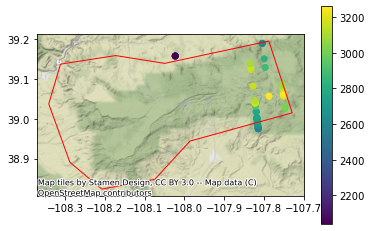

In [44]:
parms = {"poly": grand_mesa,
"srt": icesat2.SRT_LAND,
"cnf": [2],
"len": 100.0,
"res": 50.0,
"maxi": 1,
"atl08_class":"atl08_ground",
"t0":'2019-12-10T00:00:00Z',
"t1":'2020-04-12T00:00:00Z'}

rsps = icesat2.atl06p(parms)
rsps = rsps[rsps.h_sigma < 0.1]
rsps = rsps[rsps.n_fit_photons > 200]
# rsps['time'] = rsps.index
print(rsps.size)
f, ax = plt.subplots()
rsps.plot(column = 'h_mean', ax = ax, legend = True)
gpd.read_file('grandmesa.geojson').plot(facecolor = "none", edgecolor = 'red', ax = ax)
cx.add_basemap(ax, crs=rsps.crs.to_string())
plt.show()

In [40]:
rsps.to_file(f'test.geojson')

In [46]:
rsps

,dh_fit_dy,n_fit_photons,segment_id,cycle,distance,delta_time,rms_misfit,gt,dh_fit_dx,pflags,w_surface_window_final,h_sigma,rgt,spot,h_mean,geometry
time,,,,,,,,,,,,,,,,
2020-02-12 23:26:23.293371440,0.0,235,217222,6,4.356235e+06,6.678518e+07,0.250919,50,-0.088140,0,3.000000,0.016482,737,2,2049.793250,POINT (-108.02285 39.15763)
2020-02-12 23:26:23.300420720,0.0,228,217224,6,4.356285e+06,6.678518e+07,0.343550,50,-0.099623,0,3.000000,0.022953,737,2,2045.104791,POINT (-108.02291 39.15808)
2020-02-12 23:26:23.307475136,0.0,212,217227,6,4.356335e+06,6.678518e+07,0.356926,50,-0.103887,0,3.000000,0.024546,737,2,2040.024827,POINT (-108.02296 39.15853)
2020-03-12 22:02:27.193453384,0.0,206,216236,6,4.336414e+06,6.928575e+07,0.901303,20,-0.169056,4,5.538216,0.062887,1179,5,2571.116167,POINT (-107.81400 38.97453)
2020-03-12 22:02:27.207570224,0.0,233,216241,6,4.336514e+06,6.928575e+07,1.215757,20,0.037585,0,9.478417,0.079694,1179,5,2564.742466,POINT (-107.81410 38.97543)
2020-03-12 22:02:27.242835704,0.0,215,216253,6,4.336765e+06,6.928575e+07,0.665088,20,0.143980,0,4.737748,0.046792,1179,5,2573.216535,POINT (-107.81438 38.97768)
2020-03-12 22:02:27.249841672,0.0,229,216256,6,4.336815e+06,6.928575e+07,0.680136,20,0.139020,0,4.766859,0.045525,1179,5,2580.514361,POINT (-107.81444 38.97813)
2020-03-12 22:02:27.320301888,0.0,242,216281,6,4.337316e+06,6.928575e+07,0.682779,20,0.135087,0,4.977317,0.044903,1179,5,2605.914179,POINT (-107.81497 38.98262)
2020-03-12 22:02:27.376618120,0.0,270,216301,6,4.337717e+06,6.928575e+07,1.362087,20,0.005677,4,7.730134,0.085697,1179,5,2674.576861,POINT (-107.81540 38.98622)


In [45]:
for d in np.unique(rsps.index.date):
    day = rsps[rsps.index.date == d]
    later_days = rsps[rsps.index.date > d]
    for other_date in np.unique(later_days.index.date):
        other_day = later_days[later_days.index.date == other_date]
        # Now reproject to a crs using meters
        day = day.to_crs(epsg = 3857)
        other_day = other_day.to_crs(epsg = 3857)
        # intersect = day.overlay(other_days, how='intersection')
        # Buffer and join
        day['geometry'] = day['geometry'].buffer(200)
        # intersection = gpd.sjoin(day, other_days, how='left')
        intersection = day.overlay(other_day, how='intersection', keep_geom_type=False)
        intersection = intersection.to_crs(rsps.crs)
        intersection['h_delta'] = intersection['h_mean_1'] - intersection['h_mean_2']
        if intersection.size > 0:
            print(intersection.size)
            print(res.h_delta.mean())
            f, ax = plt.subplots()
            intersection.plot(column = 'h_delta', legend = True, ax = ax, vmin = -5, vmax = 5)
            gpd.read_file('grandmesa.geojson').plot(facecolor = "none", edgecolor = 'red', ax = ax)
            cx.add_basemap(ax, crs=intersection.crs.to_string())
            plt.show()
            res = intersection.copy()